In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatter
import sys

from covid19model.data.model_parameters import get_integrated_willem2012_interaction_matrices, get_COVID19_SEIQRD_parameters
from covid19model.models.utils import read_coordinates_nis

agg = 'arr'
initN, Nc_all, _, _ = get_COVID19_SEIQRD_parameters(spatial='arr')

In [10]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", show_xlabel=True, show_ylabel=True, show_colorbar=True, vmin=None, vmax=None, ticks=None):

    if not ax:
        ax = plt.gca()
        
    if not vmin:
        vmin = np.min(data)
    if not vmax:
        vmax = np.max(data)

    # Plot the heatmap
    im = ax.imshow(data, norm=colors.LogNorm(vmin=vmin, vmax=vmax))

    # Create colorbar
    if show_colorbar:
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="8%", pad=0.2)
        formatter = LogFormatter(10, labelOnlyBase=False)
        cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=ticks, format=formatter, cax=cax)# **cbar_kw) #fraction=0.046, pad=0.04, **cbar_kw)
#         cbar.set_label(cbarlabel, fontsize=12)
        cbar.ax.set_yticklabels([2000, 10000, 100000, 200000])
        # cbar.ax.set_ylabel(cbarlabel, rotation=270, fontsize=15, labelpad=15) #, va="bottom"
        # cbar = ax.figure.colorbar(im, ax=ax, fraction=0.0001, pad=0.04, **cbar_kw, rotation=270, fontsize = 15, labelpad=15)
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    if show_xlabel:
        ax.set_xticklabels(col_labels)
    else:
        ax.set_xticklabels([None]*len(col_labels))
    if show_ylabel:
        ax.set_yticklabels(row_labels)
    else:
        ax.set_yticklabels([None]*len(row_labels))

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # Rotate the tick labels and set their alignment.
    matplotlib.pyplot.setp(ax.get_xticklabels(), rotation=-90, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    if show_colorbar:
        return im, cbar
    else:
        return im

(<matplotlib.image.AxesImage at 0x175a683c5c0>,
 <matplotlib.colorbar.Colorbar at 0x175a688acf8>)

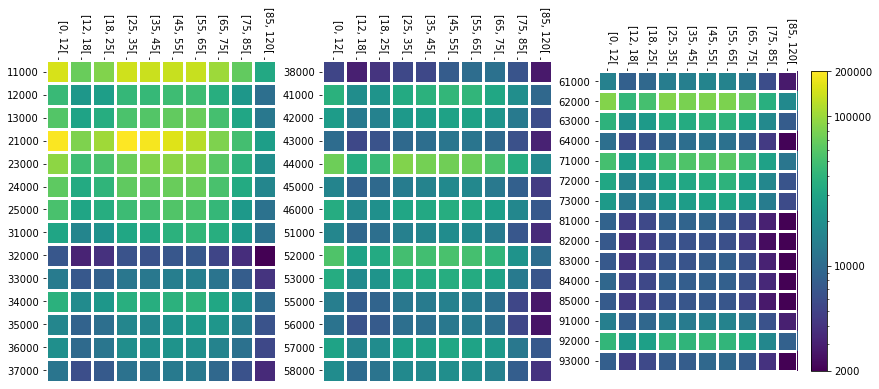

In [16]:
(G, N) = initN.shape

row_labels = read_coordinates_nis(spatial=agg)
row_labels0 = row_labels[:G//3]
initN0 = initN.values[:G//3,:]
row_labels1 = row_labels[G//3:2*G//3]
initN1 = initN.values[G//3:2*G//3,:]
row_labels2 = row_labels[2*G//3:]
initN2 = initN.values[2*G//3:,:]
# column_labels = np.array(['[0, 10[', '[10, 20[', '[20, 30[', '[30, 40[', '[40, 50[', '[50, 60[', '[60, 70[', '[70, 80[', '[80, inf['])
column_labels = np.array(['[0, 12[', '[12, 18[', '[18, 25[', '[25, 35[', '[35, 45[', '[45, 55[', '[55, 65[', '[65, 75[', '[75, 85[', '[85, 120['])


fig, axs = plt.subplots(1, 3, figsize=(14, 8))
vmin=2000
vmax=200000
ticks=[2000, 10000, 100000, 200000]
heatmap(initN0, row_labels0, column_labels, ax=axs[0], vmin=vmin, vmax=vmax, show_colorbar=False)
heatmap(initN1, row_labels1, column_labels, ax=axs[1], vmin=vmin, vmax=vmax, show_colorbar=False)
heatmap(initN2, row_labels2, column_labels, ax=axs[2], vmin=vmin, vmax=vmax, ticks=ticks)

# plt.savefig('pop_per_arr.png', dpi=400, bbox_inches='tight')

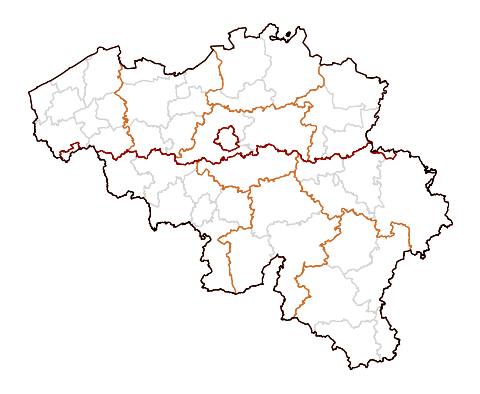

In [87]:
# Data analysis package, numerical package, plotting package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use datetime format in indices
import datetime

import geopandas as gp
from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics

# Import nice colors for plotting
from matplotlib import colors

# Import operation system module to create directories
import os


# Load different geographical aggregations
country = gp.read_file("..\..\..\COVID19_spatial_private\data\GIS_layers\AD_6_Country.shp")
regions = gp.read_file("..\..\..\COVID19_spatial_private\data\GIS_layers\AD_5_Region.shp")
provinces = gp.read_file("..\..\..\COVID19_spatial_private\data\GIS_layers\AD_4_Province.shp")
arrondissements = gp.read_file("..\..\..\COVID19_spatial_private\data\GIS_layers\AD_3_District.shp")
municipalities = gp.read_file("..\..\..\COVID19_spatial_private\data\GIS_layers\AD_2_Municipality.shp")

# Show different geographical aggregations on the same axes
# ax = municipalities.plot(figsize = (12,7), color='none', edgecolor = 'whitesmoke')
ax = arrondissements.plot(figsize = (12,7), color='none', edgecolor = 'lightgrey')
# arrondissements.plot(color='none', edgecolor = 'lightgrey', ax=ax)
provinces.plot(color='none', edgecolor = 'chocolate', ax=ax)
regions.plot(color='none', edgecolor = 'darkred', ax=ax)
country.plot(color='none', edgecolor = 'k', ax=ax)
ax.set_axis_off()

# Add NIS-code to Arrondissement Brussel-Hoofdstad
provinces.loc[provinces['NISCode']=='NA', 'NISCode'] = '21000'

# Add Dutch names
provinces.loc[provinces['NISCode'] == 'NA', 'NameDut'] = 'Brussel'
provinces.loc[provinces['NISCode'] == '20002', 'NameDut'] = 'Waals-Brabant'
provinces.loc[provinces['NISCode'] == '60000', 'NameDut'] = 'Luik'
provinces.loc[provinces['NISCode'] == '80000', 'NameDut'] = 'Luxemburg'
provinces.loc[provinces['NISCode'] == '90000', 'NameDut'] = 'Namen'

# fig = ax.get_figure()
# fig.savefig('test', bbox_inches='tight')

In [70]:
arrondissements = arrondissements.merge(initN.sum(axis=1).to_frame().reset_index().astype(str), left_on='NISCode', right_on='NIS')
arrondissements = arrondissements.drop(columns=['NIS'])

initN.sum(axis=1).to_frame().reset_index().astype(str)

arrondissements = arrondissements.rename(columns={0 : "population"})
arrondissements['density'] = arrondissements['population'].astype(int)/arrondissements['Shape_Area']*1e6

<AxesSubplot:>

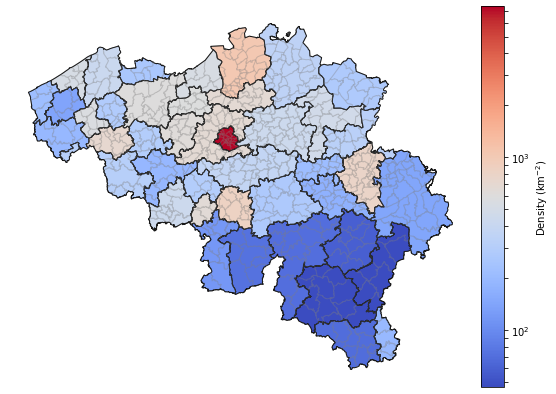

In [86]:
# Make figure
fig, ax = plt.subplots(figsize = (12,7)) # 1200 pixels x 1200 pixels
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
ax.set_axis_off()

vmin = arrondissements.density.min()
vmax = arrondissements.density.max()
fig = arrondissements.plot(column='density', ax=ax, cmap='coolwarm',
                            legend=True, edgecolor = 'k', norm=colors.SymLogNorm(1, vmin=vmin, vmax=vmax), cax=cax,
                            legend_kwds={'label': "Density (km$^{-2}$)"})

municipalities.plot(color='none', edgecolor='grey', ax=ax, alpha=0.2)
# textbox = 'Days of delay to ' + prov + '\nHospitalised per 100k'
# plt.figtext(.15, .30, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
# plt.close()

# (Create directory and) save figure
# path = '../figures/maps/provinces/time_series_tests/'
# chart = fig.get_figure()
# chart.savefig('time-delays_prov_to_' + prov + '.jpg' ,dpi=50, bbox_inches='tight')

In [89]:
initN, Nc_all, _, _ = get_COVID19_SEIQRD_parameters(spatial='mun')

municipalities = municipalities.merge(initN.sum(axis=1).to_frame().reset_index().astype(str), left_on='NISCode', right_on='NIS')
municipalities = municipalities.drop(columns=['NIS'])

initN.sum(axis=1).to_frame().reset_index().astype(str)

municipalities = municipalities.rename(columns={0 : "population"})
municipalities['density'] = municipalities['population'].astype(int)/municipalities['Shape_Area']*1e6

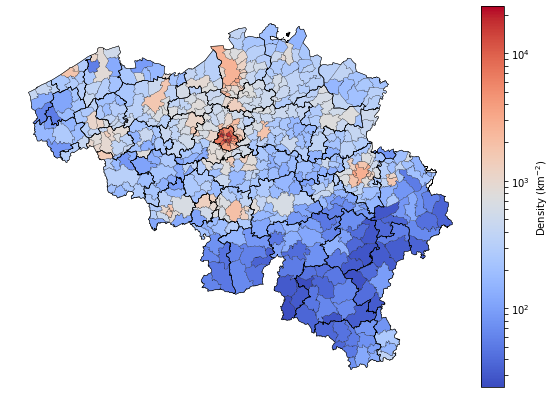

In [99]:
# Make figure
fig, ax = plt.subplots(figsize = (12,7)) # 1200 pixels x 1200 pixels
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
ax.set_axis_off()

vmin = municipalities.density.min()
vmax = municipalities.density.max()
fig = municipalities.plot(column='density', ax=ax, cmap='coolwarm', linewidth=0.2,
                            legend=True, edgecolor = 'k', norm=colors.SymLogNorm(1, vmin=vmin, vmax=vmax), cax=cax,
                            legend_kwds={'label': "Density (km$^{-2}$)"})

arrondissements.plot(color='none', edgecolor='k', ax=ax, linewidth=0.5)
# textbox = 'Days of delay to ' + prov + '\nHospitalised per 100k'
# plt.figtext(.15, .30, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
# plt.close()

# (Create directory and) save figure
# path = '../figures/maps/provinces/time_series_tests/'
chart = fig.get_figure()
# chart.savefig('population-densities_mun.jpeg' ,dpi=400, bbox_inches='tight')